Importing required packages

In [23]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from scipy import stats
from scipy.stats import wilcoxon, t
import altair as alt

# Set Pandas options to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)  # Set to None to display all text in a column

# # Also, increase the width of the output to prevent truncation
# pd.set_option('display.width', 1000)

Loading data

In [24]:
# Load the CSV file
file_path = './data/final-study-raw-2.csv'
df = pd.read_csv(file_path)

# df.head(10)



Add a field named isCorrectlyAnswered

In [25]:
# List of factual trialIds
factual_trial_ids = [
    'Covid-Vis-Q1', 'Covid-Text-Q1', 'Covid-Both-Q1',
    'Tennis-Vis-Q1', 'Tennis-Text-Q1', 'Tennis-Both-Q1',
    'Organizations-Vis-Q1', 'Organizations-Text-Q1', 'Organizations-Both-Q1'
]

# List of factual responseIds (for simplicity, assuming they are the same across all these trialIds)
factual_response_ids = ['voq1', 'voq2', 'voq3', 'voq4', 'voq5', 'voq6', 'voq7', 'voq8']

training_trial_ids = ['Training 1', 'Training 2', 'Training 3']
training_response_ids = ['1', '2', '3']



# Function to determine if the answer is correct or should be marked as "undefined"
def is_correctly_answered(row):
    if (row['trialId'] in factual_trial_ids and row['responseId'] in factual_response_ids) or \
       (row['trialId'] in training_trial_ids and row['responseId'] in training_response_ids):
        # Check if the trial is one of the special cases where order doesn't matter
        if row['trialId'] in ['Covid-Vis-Q1', 'Covid-Text-Q1', 'Covid-Both-Q1', 
                              'Organizations-Vis-Q1', 'Organizations-Text-Q1', 'Organizations-Both-Q1'] and \
           row['responseId'] in ['voq3']:  # Add any other responseId that requires set comparison
            
            # Split the answers into sets and compare them
            correct_answer_set = set(row['correctAnswer'].split(','))
            answer_set = set(row['answer'].split(','))
            return correct_answer_set == answer_set
        
        else:
            # For all other cases, do a direct string comparison
            return row['answer'] == row['correctAnswer']
    else:
        return "undefined"

# Add the isCorrectlyAnswered column
df['isCorrectlyAnswered'] = df.apply(is_correctly_answered, axis=1)

# Reorder columns to place isCorrectlyAnswered right after correctAnswer
cols = df.columns.tolist()
correct_answer_index = cols.index('correctAnswer')
cols.insert(correct_answer_index + 1, cols.pop(cols.index('isCorrectlyAnswered')))
df = df[cols]

df.head(10)  # Displaying the first 50 rows for verification

,participantId,trialId,trialOrder,responseId,status,percentComplete,description,instruction,responsePrompt,answer,correctAnswer,isCorrectlyAnswered,responseMin,responseMax,startTime,endTime,duration,configHash
0,574dc90512d86b000f833ab0,Consent,1,id,completed,100.0,undefined,undefined,Please enter your Prolific ID,574dc90512d86b000f833ab0,undefined,undefined,undefined,undefined,2024-08-21T22:50:10.140Z,2024-08-21T22:51:05.223Z,55083,77caca98fb0227c12c5e3cf1c0c50d0fe0114a9d1132e441e4e281cc92353a09
1,574dc90512d86b000f833ab0,Consent,1,consent,completed,100.0,undefined,undefined,Do you consent to the study and wish to continue?,yes,undefined,undefined,undefined,undefined,2024-08-21T22:50:10.140Z,2024-08-21T22:51:05.223Z,55083,77caca98fb0227c12c5e3cf1c0c50d0fe0114a9d1132e441e4e281cc92353a09
2,574dc90512d86b000f833ab0,Training 1,3,1,completed,100.0,undefined,Please answer the following questions:,What is the largest set?,Action,Action,True,undefined,undefined,2024-08-21T22:54:58.604Z,2024-08-21T22:59:43.071Z,284467,77caca98fb0227c12c5e3cf1c0c50d0fe0114a9d1132e441e4e281cc92353a09
3,574dc90512d86b000f833ab0,Training 1,3,2,completed,100.0,undefined,Please answer the following questions:,What is the largest intersection?,Empty Intersection (no sets),Empty Intersection (no sets),True,undefined,undefined,2024-08-21T22:54:58.604Z,2024-08-21T22:59:43.071Z,284467,77caca98fb0227c12c5e3cf1c0c50d0fe0114a9d1132e441e4e281cc92353a09
4,574dc90512d86b000f833ab0,Training 1,3,3,completed,100.0,undefined,Please answer the following questions:,How many sets make up the largest intersection?,It is the empty intersection (no sets),It is the empty intersection (no sets),True,undefined,undefined,2024-08-21T22:54:58.604Z,2024-08-21T22:59:43.071Z,284467,77caca98fb0227c12c5e3cf1c0c50d0fe0114a9d1132e441e4e281cc92353a09
5,574dc90512d86b000f833ab0,Training 2,4,1,completed,100.0,undefined,Please answer the following questions:,What is the largest set?,Adventure,Adventure,True,undefined,undefined,2024-08-21T22:59:43.095Z,2024-08-21T23:01:05.040Z,81945,77caca98fb0227c12c5e3cf1c0c50d0fe0114a9d1132e441e4e281cc92353a09
6,574dc90512d86b000f833ab0,Training 2,4,2,completed,100.0,undefined,Please answer the following questions:,What is the largest intersection?,Adventure,Adventure,True,undefined,undefined,2024-08-21T22:59:43.095Z,2024-08-21T23:01:05.040Z,81945,77caca98fb0227c12c5e3cf1c0c50d0fe0114a9d1132e441e4e281cc92353a09
7,574dc90512d86b000f833ab0,Training 2,4,3,completed,100.0,undefined,Please answer the following questions:,How many sets make up the largest intersection?,It is only of a single set,It is only of a single set,True,undefined,undefined,2024-08-21T22:59:43.095Z,2024-08-21T23:01:05.040Z,81945,77caca98fb0227c12c5e3cf1c0c50d0fe0114a9d1132e441e4e281cc92353a09
8,574dc90512d86b000f833ab0,Training 3,5,1,completed,100.0,undefined,Please answer the following questions:,What is the largest set?,Drama,Drama,True,undefined,undefined,2024-08-21T23:01:05.062Z,2024-08-21T23:01:37.516Z,32454,77caca98fb0227c12c5e3cf1c0c50d0fe0114a9d1132e441e4e281cc92353a09
9,574dc90512d86b000f833ab0,Training 3,5,2,completed,100.0,undefined,Please answer the following questions:,What is the largest intersection?,Drama,Drama,True,undefined,undefined,2024-08-21T23:01:05.062Z,2024-08-21T23:01:37.516Z,32454,77caca98fb0227c12c5e3cf1c0c50d0fe0114a9d1132e441e4e281cc92353a09


1. Filtering out the "completed" studies (removing the pending and rejected ones)
2. Adding a column named dataset
3. Deleting "configHash" colum
4. Saving all of these in a new csv file

In [26]:
# Filter rows where 'Status' is 'completed'
filtered_df = df[df['status'] == 'completed']

# Count the number of unique participants
unique_participant_count = filtered_df['participantId'].nunique()

# Print the number of unique participants
print(f"Number of unique participants: {unique_participant_count}")

# Define the participantId to be removed
participants_to_remove = ['e78b4a59-2483-4f3b-a4b1-e046e06e1e26', '66a13fdf279c038ba8aa5ae6']

# Filter out the rows with the specified participantId
filtered_df = filtered_df[~filtered_df['participantId'].isin(participants_to_remove)]

# Add the dataset column based on the conditions
def determine_dataset(trial_id):
    if 'Covid' in trial_id:
        return 'Covid Symptoms'
    elif 'Tennis' in trial_id:
        return 'Tennis Grand Slam Winners'
    elif 'Organizations' in trial_id:
        return 'International Organizations'
    elif 'Training' in trial_id:
        return 'Movie Genres'
    else:
        return 'Undefined'

filtered_df['dataset'] = filtered_df['trialId'].apply(determine_dataset)

# Delete the specified columns
filtered_df = filtered_df.drop(columns=['instruction', 'configHash'])

# Save the filtered data to a new CSV file
new_file_path = './data/final-study.csv'
filtered_df.to_csv(new_file_path, index=False)

print(f"Filtered data saved to: {new_file_path}")


Number of unique participants: 84
Filtered data saved to: ./data/final-study.csv


1. Separating three conditions (Vis, Text, Both) in three different files 
2. Using "Survey.csv" only to plot likert scale answers

In [27]:
# Define the middle part of the conditions
conditions = ['Text', 'Both', 'Vis', 'Survey']

# Generate separate CSV files for each condition
for condition in conditions:
    # Filter the DataFrame based on the presence of the condition in 'trialId'
    condition_df = filtered_df[filtered_df['trialId'].str.contains(condition)]
    
    # Save the filtered data to a new CSV file
    new_file_path = f'./data/{condition}_data.csv'
    condition_df.to_csv(new_file_path, index=False)
    
    print(f"Filtered data for condition '{condition}' saved to: {new_file_path}")

Filtered data for condition 'Text' saved to: ./data/Text_data.csv
Filtered data for condition 'Both' saved to: ./data/Both_data.csv
Filtered data for condition 'Vis' saved to: ./data/Vis_data.csv
Filtered data for condition 'Survey' saved to: ./data/Survey_data.csv


Counting post survey preferences and effectiveness

In [28]:


# Load the CSV data
data = pd.read_csv('./data/Survey_data.csv')

# Filter relevant columns for analysis
columns_of_interest = ['participantId', 'trialId', 'responseId', 'responsePrompt', 'answer']
filtered_data = data[columns_of_interest]

# Analyze responses to "Which presentation modality did you find most effective?"
most_effective = filtered_data[filtered_data['responsePrompt'] == 'Which presentation modality did you find most effective?']['answer']

# Analyze responses to "Which condition did you find the least effective?"
least_effective = filtered_data[filtered_data['responsePrompt'] == 'Which condition did you find the least effective?']['answer']

# Analyze responses to "If you were to receive information in the future, which format would you prefer?"
preferred_format = filtered_data[filtered_data['responsePrompt'] == 'If you were to receive information in the future, which format would you prefer?']['answer']

# Create counters for each question
most_effective_counts = Counter(most_effective)
least_effective_counts = Counter(least_effective)
preferred_format_counts = Counter(preferred_format)

most_effective_counts, least_effective_counts, preferred_format_counts


(Counter({'Text and Visualization Combined': 57,
          'Just Visualization': 18,
          'Just Text Description': 8}),
 Counter({'Just Text Description': 57,
          'Just Visualization': 23,
          'Text and Visualization Combined': 3}),
 Counter({'Text and Visualization Combined': 60,
          'Just Visualization': 15,
          'Just Text Description': 8}))

Plotting the result for pereferences and the effectiveness

Most Effective: [18, 57, 8]
Least Effective: [23, 3, 57]
Preferred Format: [15, 60, 8]


/var/folders/t8/_mskc89n2_g3fy90ggktqfxm0000gn/T/ipykernel_11126/2735830496.py:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melted[df_melted['Category'] == title], x='Condition', y='Count', ax=ax, palette='viridis', ci=None)
/var/folders/t8/_mskc89n2_g3fy90ggktqfxm0000gn/T/ipykernel_11126/2735830496.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_melted[df_melted['Category'] == title], x='Condition', y='Count', ax=ax, palette='viridis', ci=None)
/var/folders/t8/_mskc89n2_g3fy90ggktqfxm0000gn/T/ipykernel_11126/2735830496.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=8)
/var/folders/t8/_mskc

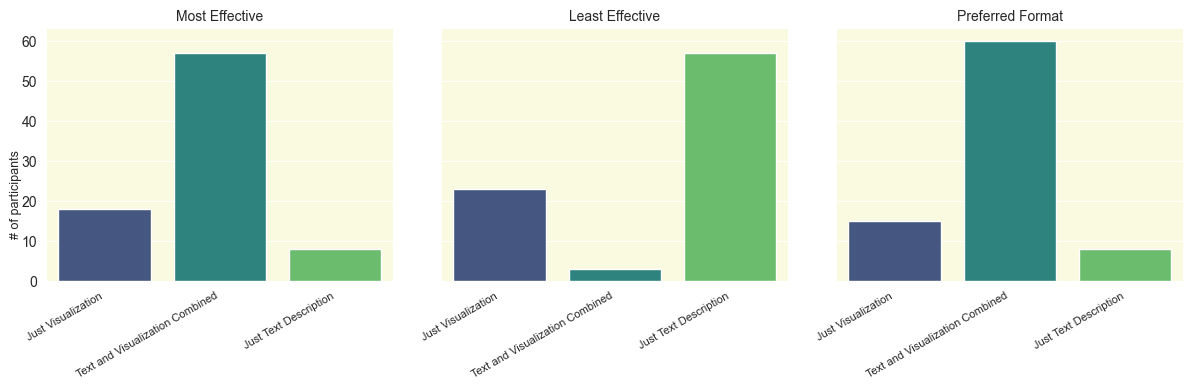

In [29]:
# Example DataFrame

conditions = ['Just Visualization', 'Text and Visualization Combined', 'Just Text Description']
# Initialize lists for counts
most_effective_list = [most_effective_counts.get(cond, 0) for cond in conditions]
least_effective_list = [least_effective_counts.get(cond, 0) for cond in conditions]
preferred_format_list = [preferred_format_counts.get(cond, 0) for cond in conditions]

# Print results to verify
print('Most Effective:', most_effective_list)
print('Least Effective:', least_effective_list)
print('Preferred Format:', preferred_format_list)

data = {
    'Condition': conditions,
    'Most Effective': most_effective_list,
    'Least Effective': least_effective_list,
    'Preferred Format': preferred_format_list
}
df = pd.DataFrame(data)

# Melt the DataFrame for easier plotting
df_melted = df.melt(id_vars='Condition', var_name='Category', value_name='Count')

# Seaborn settings
# sns.set_style("whitegrid")
sns.set_style("whitegrid", {'axes.facecolor': (0.98, 0.98, 0.88), 'grid.color': 'white'})

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True, facecolor='white')

# Define titles
titles = ['Most Effective', 'Least Effective', 'Preferred Format']

# Plotting
palette = sns.color_palette("husl", len(conditions)) 
for ax, title in zip(axs, titles):
    sns.barplot(data=df_melted[df_melted['Category'] == title], x='Condition', y='Count', ax=ax, palette='viridis', ci=None)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('')
    # ax.set_ylabel('# of participants', fontsize=8)
    ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=8)
    ax.set_facecolor((0.98, 0.98, 0.88))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)


# Set common y-label
fig.text(0.01, 0.5, '# of participants', va='center', rotation='vertical', fontsize=9)

# # Remove gridlines
# for ax in axs:
#     ax.grid(False)

fig.savefig('./figures/effectiveness-analysis.pdf', dpi=500, bbox_inches='tight')

plt.tight_layout()
plt.show()



In [44]:
# Load the main CSV file
file_path = './data/final-study.csv'
df = pd.read_csv(file_path)
# Count the number of unique participantId
unique_count = df['participantId'].nunique()

# Get the unique participantIds
unique_ids = df['participantId'].unique()

print(f"The number of unique participantId is: {unique_count}")
print("The unique participantIds are:")
print(unique_ids)


# Define the columns to display
columns_of_interest = ['participantId','trialId', 'responseId', 'responsePrompt', 'answer', 'correctAnswer','isCorrectlyAnswered','dataset']
ans_df = df[columns_of_interest]

# Display the filtered dataframe
ans_df.head()


The number of unique participantId is: 84
The unique participantIds are:
['574dc90512d86b000f833ab0' '5755c957eb80c4000741a9ce'
 '5955a3eb98c9c400019f5c5f' '597fe89a1b41a20001749f57'
 '5997043dbbe84800017964a7' '5a893c8cf49c9a0001f3a221'
 '5aebc4ac75deca00016252ea' '5ba855d47c0ebe0001272f70'
 '5bf60707345b9b00016f0e97' '5c6c260dce4e560001f75731'
 '5dd71896670d1a6af9f20eee' '5deb9c5a4de9422935efe5e7'
 '5dff767f69a117bc2fbd4be8' '5e02e5144acfb9e385bb4c5a'
 '5e63cacbe43f28152567f42b' '5ecc0077922a5d0a247e79ac'
 '5ece9e3b3a19db0cf5af6692' '5ed7b0c59a2ae024836e32d5'
 '5ee1cf1e0df8e55c6b9e1f1a' '5efb49177e130c0785b93842'
 '5f4fc497a3b4320c8928639e' '6008793f0294554adc85c346'
 '60188c50141a9415c30301e0' '603d90a1cd5c8ec6df906814'
 '60fcd02deba2c8e1ed1f0723' '61080d1c39e080da7841eade'
 '610f7244c65ae4e57858a700' '611116ac01f43eeeb3cdeff3'
 '6131597390b9cf1cfc3e8a76' '628254ec789e78a3dcd22d99'
 '62bb4c95ca36f792585cb4b5' '6315ffdb9876ded7feefaf07'
 '63ea445c759d5bf0e3f63739' '641ecfa9f83175a3d9

,participantId,trialId,responseId,responsePrompt,answer,correctAnswer,isCorrectlyAnswered,dataset
0,574dc90512d86b000f833ab0,Consent,id,Please enter your Prolific ID,574dc90512d86b000f833ab0,undefined,undefined,Undefined
1,574dc90512d86b000f833ab0,Consent,consent,Do you consent to the study and wish to continue?,yes,undefined,undefined,Undefined
2,574dc90512d86b000f833ab0,Training 1,1,What is the largest set?,Action,Action,True,Movie Genres
3,574dc90512d86b000f833ab0,Training 1,2,What is the largest intersection?,Empty Intersection (no sets),Empty Intersection (no sets),True,Movie Genres
4,574dc90512d86b000f833ab0,Training 1,3,How many sets make up the largest intersection?,It is the empty intersection (no sets),It is the empty intersection (no sets),True,Movie Genres


Percentage of Answering Correcty (based on Text, Both and Vis for each dataset (covid-text-Q1, covid-vis-Q1, etc. and training dataset)

In [45]:
# Load the data from prep-pilot.csv
file_path = './data/final-study.csv'
df = pd.read_csv(file_path)

# Define the trialIds of interest
trial_ids_of_interest = [
    'Covid-Vis-Q1', 'Covid-Text-Q1', 'Covid-Both-Q1',
    'Tennis-Vis-Q1', 'Tennis-Text-Q1', 'Tennis-Both-Q1',
    'Organizations-Vis-Q1', 'Organizations-Text-Q1', 'Organizations-Both-Q1'
]

# Filter the dataframe to include only rows with the specified trialIds
dataset_df = df[df['trialId'].isin(trial_ids_of_interest)]

print("Only the below trialIds have factual questions:")
print(dataset_df['trialId'].value_counts()/8)
dataset_df.head(10)

# Convert 'isCorrectlyAnswered' from string to boolean
dataset_df['isCorrectlyAnswered'] = dataset_df['isCorrectlyAnswered'].apply(lambda x: True if x == 'True' else False if x == 'False' else x)

# Ensure isCorrectlyAnswered is boolean and filter out non-boolean values
filterCorrectAnswer_df = dataset_df[dataset_df['isCorrectlyAnswered'].isin([True, False])]
filterCorrectAnswer_df.head(10)

# print(filterCorrectAnswer_df['isCorrectlyAnswered'].value_counts())

# Calculate the percentage of correctly answered trials for each trialId
percentage_correct_by_trialid = filterCorrectAnswer_df.groupby('trialId')['isCorrectlyAnswered'].mean() * 100

# Display the results
print("Percentage of correctly answered trials for each trialId of having factual questions:")
print(percentage_correct_by_trialid)


Only the below trialIds have factual questions:
trialId
Tennis-Text-Q1           30.0
Covid-Both-Q1            29.0
Organizations-Both-Q1    29.0
Organizations-Vis-Q1     28.0
Covid-Vis-Q1             28.0
Organizations-Text-Q1    27.0
Tennis-Vis-Q1            27.0
Covid-Text-Q1            26.0
Tennis-Both-Q1           26.0
Name: count, dtype: float64
Percentage of correctly answered trials for each trialId of having factual questions:
trialId
Covid-Both-Q1            95.689655
Covid-Text-Q1            86.057692
Covid-Vis-Q1             95.089286
Organizations-Both-Q1    89.655172
Organizations-Text-Q1    87.962963
Organizations-Vis-Q1     87.053571
Tennis-Both-Q1           81.730769
Tennis-Text-Q1           87.500000
Tennis-Vis-Q1            79.166667
Name: isCorrectlyAnswered, dtype: float64


/var/folders/t8/_mskc89n2_g3fy90ggktqfxm0000gn/T/ipykernel_11126/4096212739.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df['isCorrectlyAnswered'] = dataset_df['isCorrectlyAnswered'].apply(lambda x: True if x == 'True' else False if x == 'False' else x)


Percentage of Answering Correcty (based on each Visual Contents - Vis, Text or Both)

In [47]:
# Create a new column to identify the visual content type (VIS, BOTH, Text)
def get_visual_content_type(trialId):
    if 'Vis' in trialId:
        return 'VIS'
    elif 'Both' in trialId:
        return 'BOTH'
    elif 'Text' in trialId:
        return 'TEXT'
    

filterCorrectAnswer_df['VisualContentType'] = filterCorrectAnswer_df['trialId'].apply(get_visual_content_type)

# Calculate the percentage of correctly answered trials for each Visual Content Type
percentage_correct_by_visual_content = filterCorrectAnswer_df.groupby('VisualContentType')['isCorrectlyAnswered'].mean() * 100

# Display the results
print("Percentage of correctly answered cumulatively for each Visual Content Type:")
print(percentage_correct_by_visual_content)

Percentage of correctly answered cumulatively for each Visual Content Type:
VisualContentType
BOTH    89.285714
TEXT    87.198795
VIS     87.198795
Name: isCorrectlyAnswered, dtype: float64


Percentage of Answering Correcty (based on datasets)

In [48]:

# Calculate the percentage of correctly answered trials for each dataset
percentage_correct_by_dataset = filterCorrectAnswer_df.groupby('dataset')['isCorrectlyAnswered'].mean() * 100

# Display the result
print("Percentage of correctly answered answer cumulatively for each dataset (of having factual questions only):")
print(percentage_correct_by_dataset)



Percentage of correctly answered answer cumulatively for each dataset (of having factual questions only):
dataset
Covid Symptoms                 92.469880
International Organizations    88.244048
Tennis Grand Slam Winners      82.981928
Name: isCorrectlyAnswered, dtype: float64


Printing the answers of "What are the insights and takeaways about the data"? (Q3 of all conditions)

In [49]:


# Load the data from prep-pilot.csv
file_path = './data/final-study.csv'
df = pd.read_csv(file_path)

# Define the Q3 trialIds of interest
q3_trial_ids = [
    'Covid-Vis-Q3', 'Covid-Text-Q3', 'Covid-Both-Q3',
    'Tennis-Vis-Q3', 'Tennis-Text-Q3', 'Tennis-Both-Q3',
    'Organizations-Vis-Q3', 'Organizations-Text-Q3', 'Organizations-Both-Q3'
]

# Filter the dataframe to include only rows with the specified Q3 trialIds
q3_df = df[df['trialId'].isin(q3_trial_ids)]

# Print the answers for all the Q3 trialIds
pd.set_option('display.max_colwidth', None)
(q3_df[['trialId','answer']])


,trialId,answer
22,Covid-Text-Q3,The set sizes have a lot of variation but the intersection properties seem very similar.
34,Organizations-Vis-Q3,There is a large divergence in the sets and the intersections.
46,Tennis-Both-Q3,Set sizes are mostly equal.
78,Organizations-Text-Q3,"That there seems to be a major overlap with the biggest organisations, and the rest are fairly insignificant."
90,Covid-Both-Q3,"It shows how fatigue is consistently the most common trait, both by itself and intersecting with other symptoms, and that diarrhea and shortness of breath seem to be mostly unrelated to having covid."
102,Tennis-Vis-Q3,That generally winners specialise in only one thing or are good at everything. It's rare for them to specialise in two things rather than one/all.
134,Covid-Both-Q3,It is a little repetitive.
146,Organizations-Vis-Q3,I think the set is about government organizations but I'm not sure.
158,Tennis-Text-Q3,This was the easiest data to comprehend.
190,Covid-Both-Q3,This is a good way to visualize data where there are multiple inputs such as symptoms to see if there is a relationship between the symptoms.


Completion time VS overall correctness

Only the below trialIds have factual questions:
trialId
Covid-Vis-Q1             23.0
Tennis-Both-Q1           20.0
Tennis-Text-Q1           20.0
Organizations-Both-Q1    20.0
Covid-Text-Q1            17.0
Organizations-Vis-Q1     17.0
Organizations-Text-Q1    17.0
Covid-Both-Q1            14.0
Tennis-Vis-Q1            14.0
Name: count, dtype: float64
(1296, 17)
(1296, 17)
(162,)
(162, 18)
(54,)


/var/folders/t8/_mskc89n2_g3fy90ggktqfxm0000gn/T/ipykernel_34386/1933905684.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall_df['isCorrectlyAnswered'] = overall_df['isCorrectlyAnswered'].apply(lambda x: True if x == 'True' else False if x == 'False' else x)


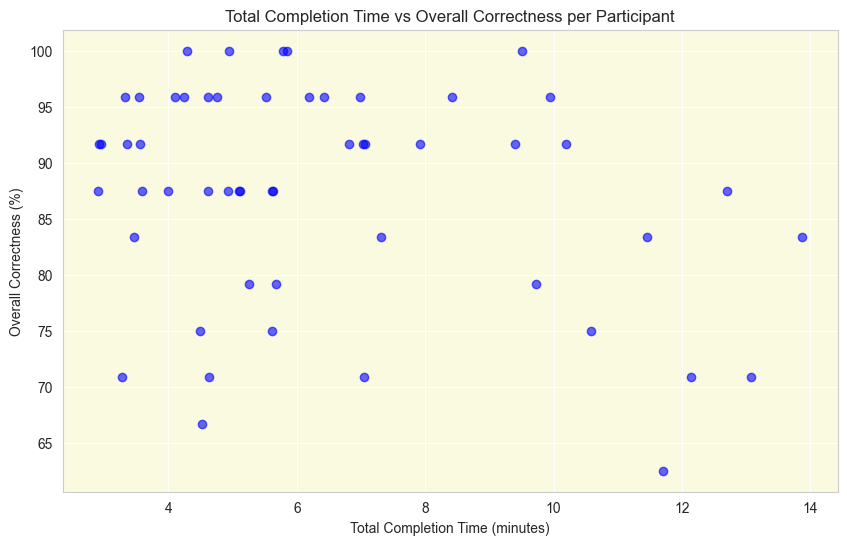

In [58]:
# Load the data from prep-pilot.csv
file_path = './data/final-study.csv'
df = pd.read_csv(file_path)

# Define the trialIds of interest
trial_ids_of_interest = [
    'Covid-Vis-Q1', 'Covid-Text-Q1', 'Covid-Both-Q1',
    'Tennis-Vis-Q1', 'Tennis-Text-Q1', 'Tennis-Both-Q1',
    'Organizations-Vis-Q1', 'Organizations-Text-Q1', 'Organizations-Both-Q1'
]

# Filter the dataframe to include only rows with the specified trialIds
overall_df = df[df['trialId'].isin(trial_ids_of_interest)]

print("Only the below trialIds have factual questions:")
print(overall_df['trialId'].value_counts()/8)
print(overall_df.shape)

# Convert 'isCorrectlyAnswered' from string to boolean
overall_df['isCorrectlyAnswered'] = overall_df['isCorrectlyAnswered'].apply(lambda x: True if x == 'True' else False if x == 'False' else x)

# Ensure isCorrectlyAnswered is boolean and filter out non-boolean values
overallCorrectAnswer_df = overall_df[overall_df['isCorrectlyAnswered'].isin([True, False])]
print(overallCorrectAnswer_df.shape)

# Calculate correctness per participant per condition
overallCorrectAnswer_df['correctAnswerNumeric'] = overallCorrectAnswer_df['isCorrectlyAnswered'].astype(int)  # Convert correctness to numeric (1 for True, 0 for False)
correctness_by_participant = overallCorrectAnswer_df.groupby(['participantId', 'trialId'])['correctAnswerNumeric'].sum()
print(correctness_by_participant.shape)

# Pivot the table to get a better structure for summing up correctness
correctness_pivot = correctness_by_participant.unstack().fillna(0)

# Calculate the overall correctness percentage per participant (sum the scores and calculate percentage)
correctness_pivot['overallCorrectness'] = (correctness_pivot.sum(axis=1) / 24) * 100

# Select the first occurrence of each trialId per participant for duration calculation
first_occurrence_df = overallCorrectAnswer_df.groupby(['participantId', 'trialId']).first().reset_index()
# print(first_occurrence_df)
print(first_occurrence_df.shape)

# Calculate the total completion time per participant in minutes by summing the first durations
total_time_by_participant = first_occurrence_df.groupby('participantId')['duration'].sum() / 60000
# print(total_time_by_participant)  # Convert milliseconds to minutes
print(total_time_by_participant.shape)

# Combine correctness and duration into a single DataFrame
summary_df = pd.DataFrame({
    'totalCompletionTime': total_time_by_participant,
    'overallCorrectness': correctness_pivot['overallCorrectness']
})

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.scatter(summary_df['totalCompletionTime'], summary_df['overallCorrectness'], color='blue', alpha=0.6)
plt.title('Total Completion Time vs Overall Correctness per Participant')
# plt.xlabel('Total Completion Time (seconds)')
plt.xlabel('Total Completion Time (minutes)')
# plt.ylabel('Overall Correctness (out of 24)')
plt.ylabel('Overall Correctness (%)')
plt.grid(True)
plt.show()




- A single plot that has three sub-plots
- Each scatter plot shows completion time vs correctness
- The color coding is based on the datasets


Only the below trialIds have factual questions:
trialId
Covid-Vis-Q1             23.0
Tennis-Both-Q1           20.0
Tennis-Text-Q1           20.0
Organizations-Both-Q1    20.0
Covid-Text-Q1            17.0
Organizations-Vis-Q1     17.0
Organizations-Text-Q1    17.0
Covid-Both-Q1            14.0
Tennis-Vis-Q1            14.0
Name: count, dtype: float64


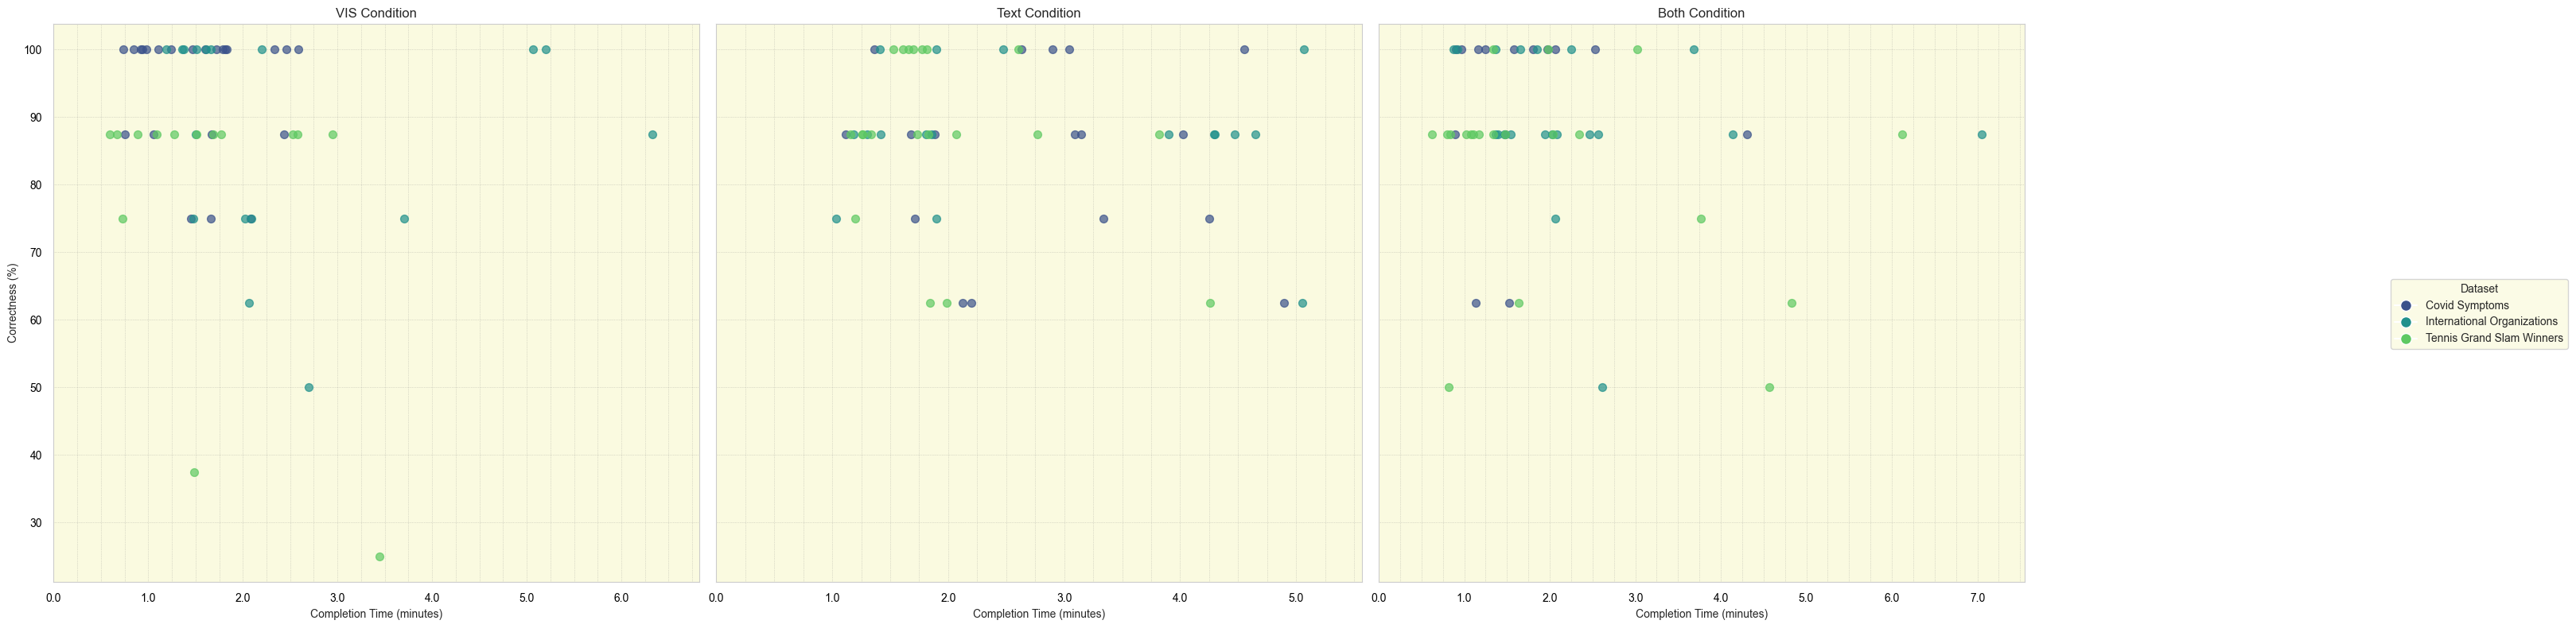

In [60]:
# Load the data from final-study.csv
file_path = './data/final-study.csv'
df = pd.read_csv(file_path)

# Define the trialIds of interest for each condition
conditions = {
    'VIS': ['Covid-Vis-Q1', 'Tennis-Vis-Q1', 'Organizations-Vis-Q1'],
    'Text': ['Covid-Text-Q1', 'Tennis-Text-Q1', 'Organizations-Text-Q1'],
    'Both': ['Covid-Both-Q1', 'Tennis-Both-Q1', 'Organizations-Both-Q1']
}

# Prepare the DataFrame to include only relevant trialIds
overall_df = df[df['trialId'].isin(sum(conditions.values(), []))]

print("Only the below trialIds have factual questions:")
print(overall_df['trialId'].value_counts()/8)

# Convert 'isCorrectlyAnswered' from string to boolean using .loc to avoid SettingWithCopyWarning
overall_df.loc[:, 'isCorrectlyAnswered'] = overall_df['isCorrectlyAnswered'].apply(lambda x: True if x == 'True' else False if x == 'False' else x)

# Ensure isCorrectlyAnswered is boolean and filter out non-boolean values
overallCorrectAnswer_df = overall_df[overall_df['isCorrectlyAnswered'].isin([True, False])]

# Calculate correctness per participant per condition
overallCorrectAnswer_df['correctAnswerNumeric'] = overallCorrectAnswer_df['isCorrectlyAnswered'].astype(int)
correctness_by_participant = overallCorrectAnswer_df.groupby(['participantId', 'trialId'])['correctAnswerNumeric'].sum().reset_index()

# Select the first occurrence of each trialId per participant for duration calculation
first_occurrence_df = overallCorrectAnswer_df.groupby(['participantId', 'trialId']).first().reset_index()

# Calculate the total completion time per participant in minutes by summing the first durations
first_occurrence_df['duration'] = first_occurrence_df['duration'] / 60000  # Convert milliseconds to minutes

# Select and sort the relevant columns
duration_table = first_occurrence_df[['participantId', 'trialId', 'duration']]
duration_table = duration_table.sort_values(['participantId', 'trialId'])

# print("\nParticipant Duration Table:")
# print(duration_table.to_string(index=False))

# Merge duration and correctness into one DataFrame, ensure correctness column is added
merged_df = pd.merge(first_occurrence_df, correctness_by_participant, on=['participantId', 'trialId'], suffixes=('', '_correct'))
merged_df['correctness'] = (merged_df['correctAnswerNumeric_correct'] / 8) * 100  # Calculate correctness percentage

# Create a plot for each condition
fig, axes = plt.subplots(1, 3, figsize=(30, 8), sharey=True)

# Get unique dataset names from the DataFrame
all_datasets = sorted(merged_df['dataset'].unique())
# print("Datasets found in the data:", all_datasets)

# Create a color palette for consistent colors across subplots
palette = sns.color_palette("viridis", n_colors=len(all_datasets))
color_dict = dict(zip(all_datasets, palette))

legend_handles = []

for ax, (condition, trial_ids) in zip(axes, conditions.items()):
    # Filter data for the current condition
    condition_df = merged_df[merged_df['trialId'].isin(trial_ids)]
    
    # Create scatter plot
    for dataset in all_datasets:
        dataset_df = condition_df[condition_df['dataset'] == dataset]
        scatter = ax.scatter(
            dataset_df['duration'],
            dataset_df['correctness'],
            c=[color_dict[dataset]],
            label=dataset,
            s=50,  # Increased point size for visibility
            alpha=0.7  # Add some transparency to help with overlapping
        )
    
    # Set titles and labels
    ax.set_title(f'{condition} Condition')
    ax.set_xlabel('Completion Time (minutes)')
    if condition == 'VIS':
        ax.set_ylabel('Correctness (%)')
    else:
        ax.set_ylabel('')
        
    # Adjust x-axis to be more granular
    max_duration = max(condition_df['duration'])
    ax.set_xlim(0, max_duration + 0.5)
    
    # Set major ticks every minute and minor ticks every 15 seconds
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
    
    # Format x-axis labels to show one decimal place
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    
    # Make ticks more visible
    ax.tick_params(which='both', direction='out', length=4, width=1, colors='black')
    ax.tick_params(which='major', length=7)
    
    # Add gridlines for better readability
    ax.grid(which='both', linestyle=':', linewidth=0.5, color='gray', alpha=0.5)

# Create legend handles manually
for dataset in all_datasets:
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[dataset], markersize=10, label=dataset))

# Add a global legend to the right of the entire figure
fig.legend(handles=legend_handles, labels=all_datasets, title='Dataset', 
           loc='center right', bbox_to_anchor=(1.08, 0.5))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.85)

# Save the figure
fig.savefig('./figures/correctness-by-each-condition.pdf', bbox_inches='tight', dpi=300)

plt.show()


Data pre-processing to plot 'Jitter plot'

In [61]:
# Load the data from final-study.csv
file_path = './data/final-study.csv'
df = pd.read_csv(file_path)

# Define the trialIds of interest for each condition
conditions = {
    'VIS': ['Covid-Vis-Q1', 'Tennis-Vis-Q1', 'Organizations-Vis-Q1'],
    'Text': ['Covid-Text-Q1', 'Tennis-Text-Q1', 'Organizations-Text-Q1'],
    'Both': ['Covid-Both-Q1', 'Tennis-Both-Q1', 'Organizations-Both-Q1']
}

# Prepare the DataFrame to include only relevant trialIds
overall_df = df[df['trialId'].isin(sum(conditions.values(), []))]
print("Only the below trialIds have factual questions:")
print(overall_df['trialId'].value_counts()/8)

# Convert 'isCorrectlyAnswered' from string to boolean
overall_df.loc[:, 'isCorrectlyAnswered'] = overall_df['isCorrectlyAnswered'].apply(lambda x: True if x == 'True' else False if x == 'False' else x)

# Ensure isCorrectlyAnswered is boolean and filter out non-boolean values
overallCorrectAnswer_df = overall_df[overall_df['isCorrectlyAnswered'].isin([True, False])]

# Calculate correctness per participant per condition
overallCorrectAnswer_df['correctAnswerNumeric'] = overallCorrectAnswer_df['isCorrectlyAnswered'].astype(int)
correctness_by_participant = overallCorrectAnswer_df.groupby(['participantId', 'trialId'])['correctAnswerNumeric'].sum().reset_index()

# Select the first occurrence of each trialId per participant for duration calculation
first_occurrence_df = overallCorrectAnswer_df.groupby(['participantId', 'trialId']).first().reset_index()

# Calculate the total completion time per participant in minutes by summing the first durations
first_occurrence_df['duration'] = first_occurrence_df['duration'] / 60000  # Convert milliseconds to minutes

# Merge duration and correctness into one DataFrame
merged_df = pd.merge(first_occurrence_df, correctness_by_participant, on=['participantId', 'trialId'], suffixes=('', '_correct'))
merged_df['correctness'] = (merged_df['correctAnswerNumeric_correct'] / 8) * 100  # Calculate correctness percentage

# Create a condition mapping based on trialId
condition_map = {
    'Covid-Vis-Q1': 'Vis', 'Tennis-Vis-Q1': 'Vis', 'Organizations-Vis-Q1': 'Vis',
    'Covid-Text-Q1': 'Text', 'Tennis-Text-Q1': 'Text', 'Organizations-Text-Q1': 'Text',
    'Covid-Both-Q1': 'Both', 'Tennis-Both-Q1': 'Both', 'Organizations-Both-Q1': 'Both'
}

# Add the condition column to merged_df based on the trialId
merged_df['condition'] = merged_df['trialId'].map(condition_map)
# print(merged_df.columns)
# print(merged_df)

# Select only the specified columns
merged_df = merged_df[['participantId', 'correctness', 'condition', 'duration']]

# Display the filtered DataFrame
# print(merged_df)
# # Add this before calculating stats
# print(merged_df.groupby('condition')['participantId'].nunique())
# print(merged_df.pivot(index='participantId', columns='condition', values='correctness').isna().sum())




Only the below trialIds have factual questions:
trialId
Covid-Vis-Q1             23.0
Tennis-Both-Q1           20.0
Tennis-Text-Q1           20.0
Organizations-Both-Q1    20.0
Covid-Text-Q1            17.0
Organizations-Vis-Q1     17.0
Organizations-Text-Q1    17.0
Covid-Both-Q1            14.0
Tennis-Vis-Q1            14.0
Name: count, dtype: float64



1. P-Value Calculation (Wilcoxon Signed-Rank Test)
    - Method Used: The p-value is calculated using the Wilcoxon Signed-Rank Test.
    - Purpose: This non-parametric test is used to compare two paired samples to determine whether their population mean ranks differ.
    - When Used: It's particularly useful when the data is not normally distributed, and you want to compare two related groups (e.g., the same participants under different conditions).
    - Implementation: The stats.wilcoxon() function from the scipy library is used to calculate the Wilcoxon Signed-Rank Test statistic (W) and the corresponding p-value.

2. Cohen's d Calculation
    - Method Used: Cohen's d is calculated using a custom function that computes the standardized mean difference between two groups.
    - Purpose: Cohen's d is a measure of effect size, which quantifies the difference between two group means in terms of standard deviation.
    - When Used: It is commonly used to express the magnitude of the difference between two groups.
3. Confidence Level
    - Method Used: A confidence interval (CI) for the mean correctness is calculated using the t-distribution.
    - Confidence Level: The confidence level used in the code is 95%.
    - Purpose: The confidence interval provides a range of values that likely contains the true mean difference between groups, considering a 95% confidence level.
    - Implementation: The t.interval() function from scipy.stats is used to calculate the CI:
        ci = t.interval(0.95, len(group)-1, loc=mean, scale=sem)

In [62]:
def add_stats(df):
    df = df.copy()

    def calculate_ci(group):
        sem = group['correctness'].sem()  # Standard Error of the Mean
        mean = group['mean'].iloc[0]  # Get the already calculated mean
        ci = t.interval(0.95, len(group)-1, loc=mean, scale=sem)  # 95% CI
        group['ci0'] = ci[0]
        group['ci1'] = ci[1]
        return group

    df['mean'] = df.groupby(['condition'], group_keys=False)['correctness'].transform('mean')
    df = df.groupby(['condition'], group_keys=False).apply(calculate_ci)
    df['mean_ci_formatted'] = df.apply(lambda row: f"{row['ci0']:.2f} — {row['mean']:.2f} — {row['ci1']:.2f}", axis=1)

    def cohens_d(group1, group2):
        mean1, mean2 = np.mean(group1), np.mean(group2)
        pooled_std = np.sqrt((np.std(group1, ddof=1) ** 2 + np.std(group2, ddof=1) ** 2) / 2)
        return (mean1 - mean2) / pooled_std

    conditions = df['condition'].unique()
    cohens_d_values = {}

    for i in range(len(conditions)):
        for j in range(i + 1, len(conditions)):
            cond1 = conditions[i]
            cond2 = conditions[j]
            group1 = df[df['condition'] == cond1]['correctness']
            group2 = df[df['condition'] == cond2]['correctness']
            cohens_d_values[(cond1, cond2)] = cohens_d(group1, group2)
            cohens_d_values[(cond2, cond1)] = cohens_d(group1, group2)  # Store both pairs


    # Pivot DataFrame to get paired samples in separate columns
    pivot_df = df.pivot(index='participantId', columns='condition', values='correctness').reset_index()
    # print("printing pivot df")
    # print(pivot_df)

    # Calculate Wilcoxon test for each pair
    wilcoxon_results = []

    # Diagnostic Code for Wilcoxon Test
    conditions_list = ['Vis', 'Text', 'Both']
    missing_data_pairs = []  # To collect pairs with insufficient data

    for i in range(len(conditions)):
        for j in range(i + 1, len(conditions)):

            cond1 = conditions_list[i]
            cond2 = conditions_list[j]
            
            # Extract paired data and drop NaN values
            data1 = pivot_df[cond1].dropna()
            data2 = pivot_df[cond2].dropna()
            
            # Print the arrays to inspect them
            # print(f"\nComparing {cond1} vs {cond2}:")
            # print(f"{cond1} data: {data1.values}")
            # print(f"{cond2} data: {data2.values}")
            # print(f"Number of valid pairs: {len(data1)}, {len(data2)}")
            
            # Check if there are any valid pairs
            if len(data1) == 0 or len(data2) == 0:
                # print(f"No valid pairs available for comparison between {cond1} and {cond2}.")
                missing_data_pairs.append((cond1, cond2))  # Record the pair with missing data
                wilcoxon_results.append({'Condition 1': cond1, 'Condition 2': cond2, 'W': np.nan, 'p': np.nan, 'd': np.nan})
            else:
                # Perform the Wilcoxon Signed-Rank Test
                w_stat, p_value = wilcoxon(data1, data2)
                # print(f"W-statistic: {w_stat}, p-value: {p_value}")
                wilcoxon_results.append({'Condition 1': cond1, 'Condition 2': cond2, 'W': w_stat, 'p': p_value, 'd': cohens_d_values.get((cond1, cond2), 'NaN')})
                # Add the new check for identical values here
                identical_values = all(data1 == data2)
                # print("Are the values identical?:", identical_values)

    wilcoxon_df = pd.DataFrame(wilcoxon_results)
    # Before merging Wilcoxon test results
    print("Wilcoxon statistical test results:")
    print(wilcoxon_df)

    # Merge these results back to the original DataFrame
    df = df.merge(wilcoxon_df, left_on='condition', right_on='Condition 1', how='left')
    
    # Check if 'd' column exists, if not, create it
    if 'd' not in df.columns:
        print("'d' column not found. Creating it with NaN values.")
        df['d'] = np.nan
    else:
        print("'d' column found. Filling NaN values.")
        df['d'] = df['d'].fillna(np.nan)

    df['n'] = df.groupby('condition')['participantId'].transform('count')

    # Handle potential NaN in 'd' values
    df['test_results'] = df.apply(lambda row: f"n={int(row['n'])}\nW={row['W']:.2f}\np={row['p']:.3f}\nd={row['d'] if pd.notna(row['d']) else 'NaN'}", axis=1)




    # After processing, report the pairs that lacked sufficient data
    if missing_data_pairs:
        print("\nPairs with insufficient data for Wilcoxon Test:")
        for pair in missing_data_pairs:
            print(f"{pair[0]} vs {pair[1]}")

    return df, wilcoxon_df

# Apply this function to your `merged_df`
stats_df, wilcoxon_df = add_stats(merged_df)
# print(stats_df.head())


Wilcoxon statistical test results:
  Condition 1 Condition 2      W         p         d
0         Vis        Text  180.0  0.165893 -0.114217
1         Vis        Both  183.5  0.440803  0.046573
2        Text        Both  272.0  0.646498 -0.071521
'd' column found. Filling NaN values.


/var/folders/t8/_mskc89n2_g3fy90ggktqfxm0000gn/T/ipykernel_34386/508288940.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['condition'], group_keys=False).apply(calculate_ci)


Jitter Plot

In [64]:

def split_beeswarm_facet(data, split_by, stats=True, legend=True):

    base = alt.Chart(data).encode(
        y=alt.Y(f"{split_by}:N", title=None).sort(["Vis", "Text", "Both"]).axis(titleFontSize=15, labelFontSize=15),
        x=alt.X("correctness:Q", 
                title="Correctness (%)",  # This adds the x-axis label
                scale=alt.Scale(domain=[0, 100], nice=False),
                axis=alt.Axis(values=list(range(0, 101, 4)), titleFontSize=15, labelFontSize=12))
    )

    if not legend:
        base = base.encode(
            color=alt.Color(f"{split_by}:N", legend=None).sort(["Vis", "Text", "Both"])
        )
    else:
        base = base.encode(
            color=alt.Color(f"{split_by}:N").sort(["Vis", "Text", "Both"]).legend(labelFontSize=15, titleFontSize=15),
        )

    point = base.mark_point(opacity=0.5, tooltip=True).transform_calculate(
        jitter='sqrt(-2*log(random()))*cos(2*PI*random())'
    ).encode(
        x=alt.X("correctness:Q", title="Correctness (%)", scale=alt.Scale(domain=[0, 100], nice=False),
                axis=alt.Axis(values=list(range(0, 101, 4)))),
        yOffset=alt.YOffset("jitter:Q"),
    )

    mean_point = base.mark_point(size=15).encode(
        x=alt.X("mean(correctness):Q", title="Correctness (%)", scale=alt.Scale(domain=[0, 100], nice=False),
                axis=alt.Axis(values=list(range(0, 101, 4))))
    )

    ci_rule = base.mark_rule(thickness=2, opacity=1, color="red", strokeWidth=2).encode(
        x=alt.X("ci0:Q", title="Correctness (%)", scale=alt.Scale(domain=[0, 100], nice=False),
                axis=alt.Axis(values=list(range(0, 101, 4)))),
        x2=alt.X2("ci1:Q", title=None),
    )

    chart = alt.layer(point, mean_point, ci_rule).properties(
        width=400,
        height=100,
    )

    if stats:
        mean_ci_text = base.mark_text(
            dx=-210, dy=8, size=10, align="right"  # Move text to the left
        ).encode(
            text=alt.Text("mean_ci_formatted:N"),
            x=alt.X("mean(correctness):Q", title="Correctness (%)", scale=alt.Scale(domain=[0, 100], nice=False),
                    axis=alt.Axis(values=list(range(0, 101, 4)))),
        )

        stat_text = base.mark_text(
            dx=0, dy=-40, size=12, align="center", fontWeight="bold"
        ).transform_filter(
            alt.datum.condition == "Both"
        ).encode(
            text=alt.Text("test_results:N"),
            x=alt.value(50),
            y=alt.value(-15),  # Positioning above the chart
            color=alt.value('gray'),
        )
    

        chart = alt.layer(point, mean_point, ci_rule, mean_ci_text, stat_text).properties(
            width=400,
            height=100,
        )

    return chart

# Generate the plot using the updated function
chart = split_beeswarm_facet(stats_df, "condition", stats=True, legend=False)
chart = chart.configure_axis(
    labelFontSize=12,
    titleFontSize=14,
    grid=True,  # Add gridlines
).configure_view(
    strokeWidth=0
).properties(
    title="Correctness by Condition"
)

chart.show()

# chart.save("./figures/statistics.svg")
# print("Chart saved as SVG")



alt.LayerChart(...)

In [66]:
import altair as alt
print(f"Altair version: {alt.__version__}")

Altair version: 5.4.0
